In [10]:
import torch
from torchvision import models
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.size'] = 13

device = 'cuda'
IMAGE_SIZE = (128, 128)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Images

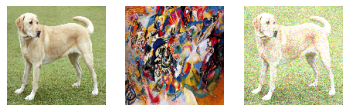

In [11]:
def load_images():
    transformer = transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE, InterpolationMode.NEAREST),
            transforms.ToTensor()
        ]
    )
    c_image = Image.open('./images/content.jpg')
    s_image = Image.open('./images/style.jpg')
    c_image = transformer(c_image).to(device)
    s_image = transformer(s_image).to(device)
    return c_image, s_image

def add_noise(c_image, ratio=0.4, requires_grad=False):
    noise = torch.rand_like(c_image) * ratio
    g_image = c_image + noise
    g_image = torch.clip(g_image, 0., 1.)
    g_image = torch.unsqueeze(g_image, 0)
    return g_image.requires_grad_(requires_grad)

def plot_images(images):
    fig = plt.figure()
    for i in range(len(images)):
        if len(images[i].shape) == 3:
            image = images[i].permute(1, 2, 0)
        else:
            image = images[i][0, ...].permute(1, 2, 0)
        if device == 'cuda':
            image = image.cpu()
        ax = fig.add_subplot(1, len(images), i + 1)
        ax.imshow(image)
        ax.set_axis_off()
    plt.show()

c_image, s_image = load_images()
g_image = add_noise(c_image)
plot_images([c_image, s_image, g_image])

### Define Model

In [12]:
class Extractor(torch.nn.Module):
    def __init__(self, output_layer_indices):
        super().__init__()
        self.output_layer_indices = torch.sort(output_layer_indices)[0]
        self.features = models.vgg19(pretrained=True).features
        for p in self.features.parameters():
            p.requires_grad = False

    def forward(self, x):
        outputs = []
        current = 0
        for i in range(self.output_layer_indices[-1] + 1):
            x = self.features[i](x)
            if i == self.output_layer_indices[current]:
                outputs.append(x)
                current += 1
        if len(outputs) == 1:
            return outputs[0]
        return outputs

c_output_layer_indices = torch.tensor([30])
c_extractor = Extractor(c_output_layer_indices).to(device)
s_output_layer_indices = torch.tensor([0, 5, 10, 19, 28])
s_extractor = Extractor(s_output_layer_indices).to(device)
s_weights = torch.tensor([1.0, 0.8, 0.7, 0.2, 0.1])

c_output = c_extractor(torch.unsqueeze(c_image, 0))
print(c_output.shape)
s_outputs = s_extractor(torch.unsqueeze(s_image, 0))
print(s_outputs[0].shape)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 512, 8, 8])
torch.Size([1, 64, 128, 128])


### Define Cost Function

In [13]:
def calc_gram_matrix(s_output, g_s_output):
    # assuming m always equals to 1
    if len(s_output.shape) == 3:
        s_output = torch.unsqueeze(s_output, 0)
        g_s_output = torch.unsqueeze(g_s_output, 0)
    m, c, w, h = s_output.shape
    s_output = torch.reshape(s_output, (m * c, w * h))
    g_s_output = torch.reshape(g_s_output, (m * c, w * h))
    s_G = s_output @ s_output.T
    g_G = g_s_output @ g_s_output.T
    return s_G, g_G

def calc_J_content(c_output, g_c_output):
    if len(c_output.shape) == 3:
        c, w, h = c_output.shape
        m = 1
    else:
        m, c, w, h = c_output.shape
    J_content = torch.sum(torch.square(c_output - g_c_output)) / (4 * m * c * w * h)
    return J_content

def calc_one_J_style(s_output, g_s_output):
    if len(s_output.shape) == 3:
        c, w, h = s_output.shape
        m = 1
    else:
        m, c, w, h = s_output.shape
    s_G, g_G = calc_gram_matrix(s_output, g_s_output)
    J_style = torch.sum(torch.square(s_G - g_G)) / (2 * m * c * w * h)**2
    return J_style

def calc_J_style(s_outputs, g_s_outputs, s_weights):
    Js = torch.zeros(len(s_outputs))
    for i in range(len(s_outputs)):
        Js[i] = calc_one_J_style(s_outputs[i], g_s_outputs[i])
    J_style = torch.sum(Js * s_weights)
    return J_style

def calc_J(alpha, beta, c_output, s_outputs, g_c_output, g_s_outputs, s_weights):
    J_content = calc_J_content(c_output, g_c_output)
    J_style = calc_J_style(s_outputs, g_s_outputs, s_weights)
    J = alpha * J_content + beta * J_style
    return J

print(calc_J(5, 5, c_image, [s_image] * 2, g_image, [g_image] * 2, torch.ones(2)))

tensor(0.4107, device='cuda:0')


### Train

epoch 0 cost=709.59


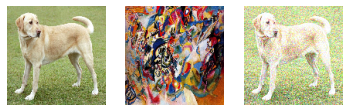

epoch 300 cost=167.09


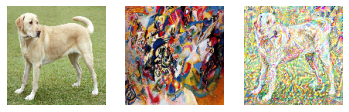

epoch 600 cost=156.49


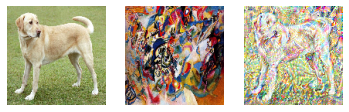

epoch 900 cost=151.97


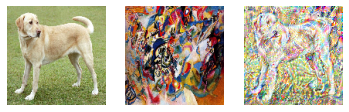

epoch 1200 cost=150.13


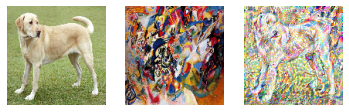

epoch 1500 cost=147.44


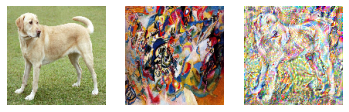

epoch 1800 cost=147.93


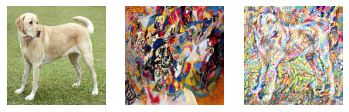

epoch 2100 cost=145.41


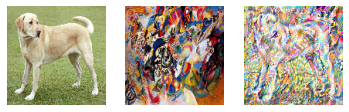

epoch 2400 cost=145.26


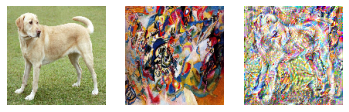

epoch 2700 cost=144.86


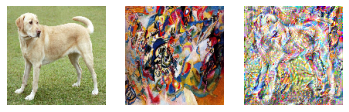

epoch 3000 cost=143.10


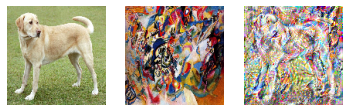

In [18]:
def train(epochs=300, lr=0.03, alpha=100, beta=100):
    "------initialize------"
    g_image = add_noise(c_image, ratio=0.4, requires_grad=True)
    optimizer = torch.optim.Adam([g_image], lr=lr)
    "------train------"
    for i in range(epochs + 1):
        optimizer.zero_grad()
        g_c_output = c_extractor(g_image)
        g_s_outputs = s_extractor(g_image)
        J = calc_J(alpha, beta, c_output, s_outputs, g_c_output, g_s_outputs, s_weights)
        J.backward()
        optimizer.step()
        "clip"
        with torch.no_grad():
            g_image.clamp_(0., 1.)
        "feedback"
        if i % (epochs // 10) == 0:
            print(f'epoch {i}', 'cost=%.2lf'%J)
            plot_images([c_image, s_image, g_image.detach()])
train(3000)